In [276]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import src

%matplotlib inline

In [277]:
df_tmdb = pd.read_csv('../zippedData/tmdb.movies.csv.gz', index_col=0)
df_budgets = pd.read_csv('tn.movie_budgets.csv')
df_rotten = pd.read_csv('rotten-sentiments.csv')
df_tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [278]:
# Clean tmdb
df_tmdb.release_date = pd.to_datetime(df_tmdb.release_date)
df_tmdb['month_day'] = df_tmdb.release_date.dt.strftime("%m%d")
df_tmdb['month'] = df_tmdb.release_date.dt.strftime("%m")
df_tmdb['year'] = df_tmdb.release_date.dt.strftime("%Y").astype(int)
df_tmdb = df_tmdb[df_tmdb.year > 2009]
tmdb_grouped = df_tmdb.groupby(['month']).id.count()


In [279]:
# Clean Budget 
print(df_budgets.shape)
df_budgets.release_date = pd.to_datetime(df_budgets.release_date)
df_budgets['month_day'] = df_budgets.release_date.dt.strftime("%m%d")
df_budgets['month'] = df_budgets.release_date.dt.strftime("%m")
df_budgets['year'] = df_budgets.release_date.dt.strftime("%Y").astype(int)
df_budgets = df_budgets[df_budgets.year > 2009]
budgets_grouped = df_budgets.groupby(['month']).id.count()


(5782, 6)


In [280]:
# in order to see how many movies were released on a given day, we have to create a subset of the data with 1 entry per movie
df_no_dup_series = df_rotten.id.drop_duplicates()
df_rotten = df_rotten.iloc[df_no_dup_series.index]
df_rotten.shape


# Clean rotten data up for merging on a month_day column
df_rotten = df_rotten[df_rotten['theater_date'].notnull()]

# convert to datetime object
df_rotten.theater_date = pd.to_datetime(df_rotten.theater_date)


df_rotten['month'] = df_rotten.theater_date.dt.strftime("%m") 
df_rotten['day'] = df_rotten.theater_date.dt.strftime('%d')
df_rotten['year'] = df_rotten.theater_date.dt.strftime('%Y').astype(int)
df_rotten['month_day'] =  df_rotten.theater_date.dt.strftime('%m%d').astype(int)

df_rotten = df_rotten[df_rotten.year > 2009]
rotten_grouped = df_rotten.groupby(['month']).id.count()

In [285]:
df_rotten[df_rotten.month_day == 1225]

,id,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,rating_y,...,writer,theater_date,dvd_date,currency,box_office,sentiment,month,day,year,month_day
803,25,Anyone who might want characters and not clich...,C-,rotten,Stephen Schaefer,0,Boston Herald,"November 29, 2017","From ancient Japan's most enduring tale, the e...",PG-13,...,Chris Morgan|Hossein Amini,2013-12-25,"Apr 1, 2014",$,"20,518,224",-0.0941,12,25,2013,1225


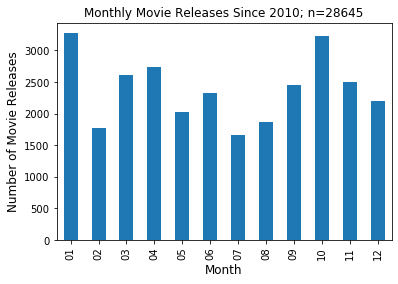

In [219]:
# I have 3 series that I would like to turn into 1 long series of their sums
monthly_series = rotten_grouped + budgets_grouped + tmdb_grouped
monthly_series.plot(kind='bar')
plt.ylabel('Number of Movie Releases', size= 12)
plt.xlabel('Month', size= 12)
plt.title(f'Monthly Movie Releases Since 2010; n={sum(series.values)}');

In [220]:
# Lets bring back rotten df and budget and look at the box office performance per month.
df_budgets = pd.read_csv('tn.movie_budgets.csv')
df_rotten = pd.read_csv('rotten-sentiments.csv')
df_tmdb = pd.read_csv('../zippedData/tmdb.movies.csv.gz', index_col=0)

In [221]:
print(src.get_iqr_median(df_tmdb, 'vote_count'))

(26.0, 5.0)


In [222]:
# Let's look at popularity as a function of release date
# Clean tmdb
df_tmdb.release_date = pd.to_datetime(df_tmdb.release_date)
df_tmdb['month_day'] = df_tmdb.release_date.dt.strftime("%m%d")
df_tmdb['month'] = df_tmdb.release_date.dt.strftime("%m").astype(int)
df_tmdb['year'] = df_tmdb.release_date.dt.strftime("%Y").astype(int)
df_tmdb = df_tmdb[(df_tmdb.year > 2009) & (df_tmdb.vote_count > 150)]
tmdb_grouped = df_tmdb.groupby(['month']).popularity.mean()

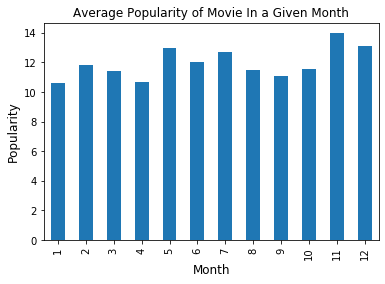

In [223]:
tmdb_grouped.plot(kind='bar')
plt.title("Average Popularity of Movie In a Given Month")
plt.ylabel("Popularity", size = 12);
plt.xlabel('Month', size = 12);

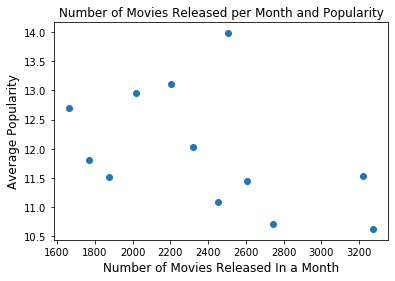

In [224]:
# Now let's plot popularity against release numbers
plt.scatter(monthly_series,tmdb_grouped)
plt.title("Number of Movies Released per Month and Popularity")
plt.xlabel("Number of Movies Released In a Month", size = 12)
plt.ylabel("Average Popularity", size = 12);

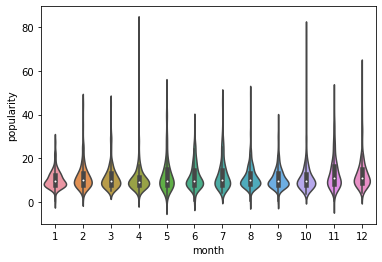

In [225]:
ax = sns.violinplot(x="month", y="popularity", data=df_tmdb)

In [226]:
df_tmdb.corr()

,id,popularity,vote_average,vote_count,month,year
id,1.000000,0.087892,0.071313,-0.115522,0.072482,0.907564
popularity,0.087892,1.000000,0.216534,0.694280,0.085307,0.209375
vote_average,0.071313,0.216534,1.000000,0.310862,0.129654,0.056147
vote_count,-0.115522,0.694280,0.310862,1.000000,0.084450,-0.000014
month,0.072482,0.085307,0.129654,0.084450,1.000000,-0.010966
year,0.907564,0.209375,0.056147,-0.000014,-0.010966,1.000000


In [227]:
# Let's look at budgets in a given month
df_budgets.release_date = pd.to_datetime(df_budgets.release_date)
df_budgets['month_day'] = df_budgets.release_date.dt.strftime("%m%d").astype(int)
df_budgets['month'] = df_budgets.release_date.dt.strftime("%m").astype(int)
df_budgets['year'] = df_budgets.release_date.dt.strftime("%Y").astype(int)
df_budgets = df_budgets[(df_budgets.year > 2009)]
df_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,month_day,month,year
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,520,5,2011
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,607,6,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,501,5,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,1215,12,2017
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,1218,12,2015


In [228]:
df_budgets['roi'] = (df_budgets['worldwide_gross']-df_budgets['production_budget'])/df_budgets['production_budget']

In [233]:
monthly_number_map_dict = {}
monthly_series.value_counts()
for month, number in zip(monthly_series.index, monthly_series.values):
    monthly_number_map_dict[int(month)] = number
monthly_number_map_dict

{1: 3274,
 2: 1770,
 3: 2604,
 4: 2743,
 5: 2019,
 6: 2322,
 7: 1662,
 8: 1873,
 9: 2451,
 10: 3220,
 11: 2503,
 12: 2204}

In [235]:
df_budgets['monthly_release']=df_budgets.month.apply(lambda x: monthly_number_map_dict[x])

In [236]:
df_budgets.corr()

,id,production_budget,domestic_gross,worldwide_gross,month_day,month,year,roi,monthly_release
id,1.000000,-0.058677,-0.018137,-0.029658,-0.016824,-0.016592,0.024780,0.032374,-0.022207
production_budget,-0.058677,1.000000,0.732027,0.793638,-0.006604,-0.005945,0.078174,-0.009964,-0.109772
domestic_gross,-0.018137,0.732027,1.000000,0.946190,0.001744,0.003324,0.078724,0.133871,-0.098325
worldwide_gross,-0.029658,0.793638,0.946190,1.000000,0.003123,0.004323,0.079775,0.122344,-0.095865
month_day,-0.016824,-0.006604,0.001744,0.003123,1.000000,0.999685,-0.040289,-0.018829,-0.060905
month,-0.016592,-0.005945,0.003324,0.004323,0.999685,1.000000,-0.039759,-0.018122,-0.060704
year,0.024780,0.078174,0.078724,0.079775,-0.040289,-0.039759,1.000000,0.021452,-0.001976
roi,0.032374,-0.009964,0.133871,0.122344,-0.018829,-0.018122,0.021452,1.000000,-0.012702
monthly_release,-0.022207,-0.109772,-0.098325,-0.095865,-0.060905,-0.060704,-0.001976,-0.012702,1.000000


In [241]:
# in order to see how many movies were released on a given day, we have to create a subset of the data with 1 entry per movie
df_no_dup_series = df_rotten.id.drop_duplicates()
df_rotten = df_rotten.iloc[df_no_dup_series.index]
df_rotten.shape


# Clean rotten data up for merging on a month_day column
df_rotten = df_rotten[df_rotten['theater_date'].notnull()]

# convert to datetime object
df_rotten.theater_date = pd.to_datetime(df_rotten.theater_date)


df_rotten['month'] = df_rotten.theater_date.dt.strftime("%m") 
df_rotten['day'] = df_rotten.theater_date.dt.strftime('%d')
df_rotten['year'] = df_rotten.theater_date.dt.strftime('%Y').astype(int)
df_rotten['month_day'] =  df_rotten.theater_date.dt.strftime('%m%d')

df_rotten = df_rotten[(df_rotten.year > 2009)]

In [253]:
sentiment_grouped = df_rotten.groupby(['month']).sentiment.median()

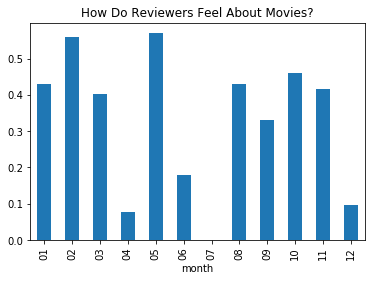

In [254]:
sentiment_grouped.plot(kind = 'bar')
plt.title('How Do Reviewers Feel About Movies?');

In [258]:
negativity = df_rotten.groupby(['publisher']).sentiment.median().sort_values()[:10]

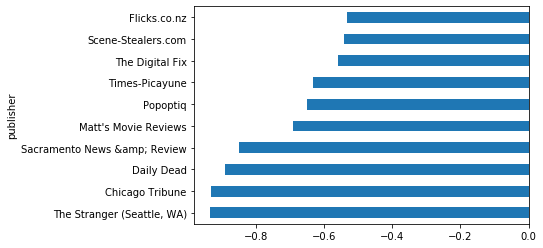

In [261]:
negativity.plot(kind='barh')
; 

In [333]:
df_sentiment =sentiment_grouped.reset_index()
df_sentiment.month =df_sentiment.month.astype(int)

df_monthly_series = monthly_series.reset_index()
df_monthly_series.columns = ['Month', 'Number of Movies']

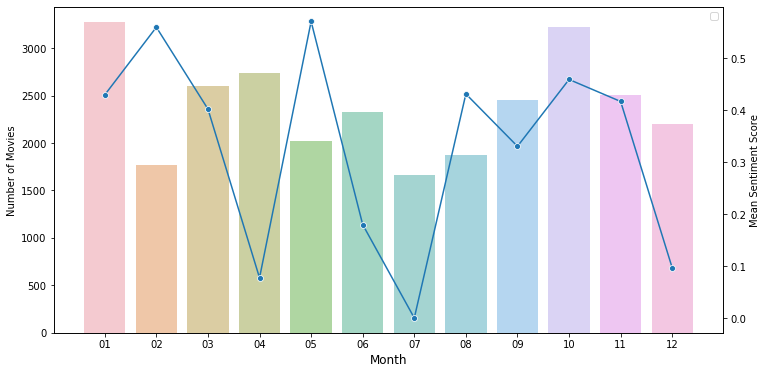

In [355]:
# Plot monthly release and sentiment value on the same plot\
# Convert monthly_series back to dataframe
monthl_number_df = monthly_series.reset_index()

# ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = df_monthly_series, x='Month', y='Number of Movies', alpha=0.5, ax=ax1)
ax1.set_xlabel(f'Month', size = 12)
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Sentiment Score')
ax2.legend('A simple line')

sns.lineplot(data = df_sentiment['sentiment'], marker='o', sort = False, ax=ax2);


In [297]:
negativity.append(monthl_number_df)

,0,id,month
"The Stranger (Seattle, WA)",-0.9344,NaN,NaN
Chicago Tribune,-0.9300,NaN,NaN
Daily Dead,-0.8910,NaN,NaN
Sacramento News &amp; Review,-0.8481,NaN,NaN
Matt's Movie Reviews,-0.6908,NaN,NaN
Popoptiq,-0.6486,NaN,NaN
Times-Picayune,-0.6305,NaN,NaN
The Digital Fix,-0.5574,NaN,NaN
Scene-Stealers.com,-0.5423,NaN,NaN
Flicks.co.nz,-0.5334,NaN,NaN


In [ ]:
# Create a graph of category and time